In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 1. Setup

In [3]:
data_dir = "Data/OHLCV"
pattern = re.compile('[A-Z]+_[A-Z]+_[0-9a-z]+.csv')
data_fns = [fn for fn in os.listdir(data_dir) if pattern.match(fn)]
print(len(data_fns))
print(data_fns[:5])

194
['ADA_BTC_1h.csv', 'ADA_ETH_1h.csv', 'ADX_BTC_1h.csv', 'ADX_ETH_1h.csv', 'AION_BNB_1h.csv']


In [4]:
symbols = []
for fn in data_fns:
    symbol = [fn.split("_")[0], fn.split("_")[1]]
    symbols.append(symbol)
symbols = pd.DataFrame(symbols, columns=['Base-Coin', 'Quote-Coin'])
symbols.head()

,Base-Coin,Quote-Coin
0,ADA,BTC
1,ADA,ETH
2,ADX,BTC
3,ADX,ETH
4,AION,BNB


In [5]:
symbols['Quote-Coin'].value_counts()

BTC     84
ETH     77
BNB     27
USDT     6
Name: Quote-Coin, dtype: int64

In [6]:
data_fp = "Data/OHLCV/BNB_BTC_1h.csv"

In [7]:
data = pd.read_csv(data_fp)
data['Open-Time'] = pd.to_datetime(data['Open-Time'])
data['Close-Time'] = pd.to_datetime(data['Close-Time'])
print(data.shape)
data.head()

(20771, 12)


,Open-Time,Open,High,Low,Close,Volume,Close-Time,Quote-Asset-Value,Number-of-Trades,Taker-Buy-Base-Asset-Volume,Taker-Buy-Quote-Asset-Volume,Ignore
0,2018-01-01 00:00:00,0.000623,0.000625,0.000614,0.000618,130791.0,2018-01-01 00:59:59,80.955613,3328.0,54856.0,33.995884,0.0
1,2018-01-01 01:00:00,0.000618,0.000625,0.000611,0.000622,89072.0,2018-01-01 01:59:59,55.013318,2653.0,39926.0,24.693081,0.0
2,2018-01-01 02:00:00,0.000622,0.000625,0.000620,0.000622,101296.0,2018-01-01 02:59:59,63.078538,2663.0,59607.0,37.145069,0.0
3,2018-01-01 03:00:00,0.000622,0.000624,0.000619,0.000622,83701.0,2018-01-01 03:59:59,52.015837,2726.0,53257.0,33.115652,0.0
4,2018-01-01 04:00:00,0.000622,0.000628,0.000622,0.000625,103000.0,2018-01-01 04:59:59,64.458631,2921.0,55663.0,34.841113,0.0


## 2. Define Dataset

In [8]:
class MarketDataset(Dataset):
    
    def __init__(self, base_coin, quote_coin, min_time, max_time, resolution, lookback_period, forecast_period, mode):
        self.base_coin = base_coin
        self.quote_coin = quote_coin
        data_fn = "{}_{}_1h.csv".format(base_coin, quote_coin)
        data_fp = os.path.join(data_dir, data_fn)
        self.data = pd.read_csv(data_fp)
        self.data['Open-Time'] = pd.to_datetime(self.data['Open-Time'])
        self.data['Close-Time'] = pd.to_datetime(self.data['Close-Time'])
        self.data = self.data[self.data['Open-Time'] >= min_time]
        self.data = self.data[self.data['Close-Time'] <= max_time]
        self.data = self.change_resolution(self.data, resolution=resolution)
        self.lookback_period = lookback_period # 24
        self.forecast_period = forecast_period # 6
        self.sequence_length = lookback_period + forecast_period # 30
        self.mode = mode # ['train', 'test', 'predict']
        if self.mode == 'predict':
            assert self.forecast_period == 1
        self.data['Close-Change'] = self.data['Close'].diff(periods=1) / self.data['Close'].shift(periods=1)
        self.data['Close-Change-Class'] = self.data['Close-Change'].apply(self.map_change)
        self.start_indices = self.find_valid_start_indices()
        self.price_columns = ['Open', 'High', 'Low', 'Close']  
        self.feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
         
        
    def aggregate_rows(self, data):
        row = {}
        row['Open-Time'] = data['Open-Time'].values[0]
        row['Close-Time'] = data['Close-Time'].values[-1]
        row['Open'] = data['Open'].values[0]
        row['Close'] = data['Close'].values[-1]
        row['High'] = data['High'].max()
        row['Low'] = data['Low'].min()
        sum_columns = ['Volume', 'Number-of-Trades', 'Taker-Buy-Base-Asset-Volume', 'Taker-Buy-Quote-Asset-Volume', 'Ignore']
        for column in sum_columns:
            row[column] = data[column].sum()
        row['Quote-Asset-Value'] = data['Quote-Asset-Value'].mean()
        return row

    def change_resolution(self, data, resolution):
        if resolution == "1h":
            return data
        elif resolution[-1] == 'h':
            n = int(resolution[:-1])
            if 24 % n != 0:
                raise ValueError("Not Defined")
        elif resolution[-1] == 'd':
            n = int(resolution[:-1]) * 24

        new_data = pd.DataFrame(columns=data.columns)
        for start_i in tqdm(range(0, len(data), n), desc="Changing Resolution"):
            row = self.aggregate_rows(data.iloc[start_i: start_i+n, :])
            new_data = new_data.append(row, ignore_index=True)
        return new_data
    
    def map_change(self, change):
        if change > 0.02:
            return 0 # buy
        elif change < -0.02:
            return 1 # sell
        else:
            return 2 # hold
        
    def find_valid_start_indices(self):
        if self.mode in ['train', 'test']:
            total_length = len(self.data) - self.sequence_length + 1 # 40 - 30 + 1
        elif self.mode == "predict":
            total_length = len(self.data) - self.lookback_period + 1 # 40 - 24 + 1 
        print("Finding valid indices...")
        start_indices = [start_index for start_index in range(total_length) if self.is_valid(start_index)]
        print("Done")
        return start_indices
    
    def is_valid(self, start_index):
        if self.mode in ['train', 'test']:
            XY = self.data.iloc[start_index: start_index+self.sequence_length]
        elif self.mode == "predict":
            XY = self.data.iloc[start_index: start_index+self.lookback_period]
        has_na = XY.isna().any().any()
        return np.invert(has_na)
        
    def __len__(self):
        return len(self.start_indices)
    
    def __getitem__(self, index):
        start_index = self.start_indices[index]
        lookback_end_time = self.data.iloc[start_index+self.lookback_period-1, :]['Open-Time'].value // 10**9
        x = self.data.iloc[start_index: start_index+self.lookback_period][self.feature_columns]
                
        min_price = x['Low'].min()
        max_price = x['High'].max()
        min_volume = x['Volume'].min()
        max_volume = x['Volume'].max()

        x[self.price_columns] = (x[self.price_columns] - min_price) / (max_price - min_price)
        x['Volume'] = (x['Volume'] - min_volume) / (max_volume - min_volume)
        x = torch.from_numpy(x.values)
        
        if self.mode in ['train', 'test']:
            y = self.data.iloc[start_index+self.lookback_period: start_index+self.sequence_length]['Close-Change-Class']
            y = torch.from_numpy(y.values)
        elif self.mode == "predict":
            y = None
        
        normalizing_parameters = [min_price, max_price, min_volume, max_volume]
        return x, y, lookback_end_time, normalizing_parameters

In [10]:
base_coin = "BNB"
quote_coin = "BTC"
dt_format = "%Y-%m-%dT%H:%M:%S"
min_time = "2018-01-01T00:00:00"
max_time = "2020-01-01T00:00:00"
resolution = "1d"
lookback_period = 30
forecast_period = 4
mode = 'train'

min_time = pd.to_datetime(min_time, format=dt_format)
max_time = pd.to_datetime(max_time, format=dt_format)

In [11]:
dataset = MarketDataset(base_coin=base_coin, 
                        quote_coin=quote_coin, 
                        min_time=min_time, 
                        max_time=max_time, 
                        resolution=resolution,
                        lookback_period=lookback_period, 
                        forecast_period=forecast_period,
                        mode=mode)


Finding valid indices...
Done


In [12]:
print(len(dataset))
dataset[0]

477


(tensor([[0.0786, 0.0822, 0.0000, 0.0489, 0.1480],
         [0.0489, 0.0848, 0.0023, 0.0741, 0.1000],
         [0.0738, 0.0824, 0.0379, 0.0603, 0.2887],
         [0.0604, 0.3559, 0.0497, 0.2681, 0.7466],
         [0.2672, 0.6805, 0.2651, 0.6072, 1.0000],
         [0.6071, 0.6318, 0.4522, 0.4751, 0.3844],
         [0.4751, 0.5613, 0.4132, 0.5209, 0.4843],
         [0.5209, 0.6098, 0.4830, 0.5225, 0.2757],
         [0.5243, 0.5259, 0.4361, 0.4953, 0.1052],
         [0.4952, 0.9441, 0.4696, 0.8118, 0.4637],
         [0.8136, 1.0000, 0.7096, 0.8303, 0.4583],
         [0.8303, 0.8539, 0.7331, 0.7823, 0.1308],
         [0.7823, 0.7951, 0.6938, 0.7589, 0.0534],
         [0.7589, 0.9135, 0.6195, 0.6958, 0.2738],
         [0.6958, 0.7007, 0.1310, 0.5202, 0.6105],
         [0.5202, 0.6271, 0.3905, 0.5804, 0.2598],
         [0.5804, 0.6477, 0.5461, 0.5731, 0.1383],
         [0.5728, 0.7646, 0.5519, 0.5912, 0.0956],
         [0.5907, 0.6001, 0.5431, 0.5634, 0.1586],
         [0.5633, 0.5736, 0.485

In [13]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
data_iter = iter(data_loader)
X, Y, _, _ = next(data_iter)
print(X.shape, Y.shape)

torch.Size([32, 30, 5]) torch.Size([32, 4])


## 3. Define the model

In [14]:
class Model(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, forecast_period):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.forecast_period = forecast_period
        output_size = num_classes * forecast_period
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def init_hidden(self, batch_size):
        h0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).double().to(device)
        c0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).double().to(device)
        return (h0, c0)
    
    def forward(self, X):
        batch_size = X.size(0)
        h0, c0 = self.init_hidden(batch_size)
        out, (ht, ct) = self.lstm(X, (h0, c0)) # out -> [batch_size, time_steps, hidden_size]
        outn = out[:,-1,:]
        outn = outn.contiguous().view(batch_size, self.hidden_size)
        outn = F.relu(self.fc1(outn))
        outn = self.fc2(outn)
        outn = outn.view((batch_size, self.num_classes, self.forecast_period))
        return outn

In [15]:
num_classes = 3
input_size = 5
hidden_size = 32
num_layers = 1
output_size = num_classes * forecast_period

In [16]:
model = Model(input_size=input_size,
              hidden_size=hidden_size, 
              num_layers=num_layers,
              num_classes=num_classes,
              forecast_period=forecast_period).double()

In [17]:
X, Y, _, _ = next(data_iter)
print(X.shape, Y.shape)
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([32, 30, 5]) torch.Size([32, 4])
torch.Size([32, 3, 4])


## 3. Define Training 

In [18]:
epochs = 10
print_every_n_epochs = epochs // 10
lr = 0.01
step_size = len(data_loader) * 1
gamma = 0.95
print(step_size)

15


In [19]:
class_counts = dataset.data['Close-Change-Class'].value_counts().sort_index()
class_weights = 1 / (class_counts ** 1)
class_weights = class_weights / class_weights.sum()
print(class_counts)
print(class_weights)
class_weights = torch.tensor(class_weights)

0    156
1    174
2    402
Name: Close-Change-Class, dtype: int64
0    0.437711
1    0.392431
2    0.169858
Name: Close-Change-Class, dtype: float64


In [20]:
criterion = nn.CrossEntropyLoss(reduction='mean', weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

In [21]:
def compute_loss(Y_pred, Y, forecast_step_weights):
    forecast_step_weights = np.array(forecast_step_weights) 
    forecast_step_weights = forecast_step_weights / forecast_step_weights.sum()
    loss = 0
    for i, forecast_step_weight in enumerate(forecast_step_weights):
        loss = loss + forecast_step_weight * criterion(Y_pred[:,:,i], Y[:,i])
    return loss

In [22]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []
forecast_step_weights = [1, 1, 1, 1]

for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
    epoch_loss = 0
    epoch_lr = 0
    
    for i, (X, Y, _, _) in tqdm(enumerate(data_loader, 1), leave=False, total=len(data_loader), desc="Epoch-{}".format(epoch)):
    #for i, (X, Y) in enumerate(train_loader, 1):
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        loss = compute_loss(Y_pred, Y, forecast_step_weights)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_last_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_last_lr()[0]
        
    epoch_loss /= len(data_loader)
    epoch_lr /= len(data_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)

Epoch:1    Loss:1.1036335420514432    LR:0.009966666666666667


Epoch:2    Loss:1.0930519523814206    LR:0.009468333333333332


Epoch:3    Loss:1.0930288259924972    LR:0.008994916666666667


Epoch:4    Loss:1.0861304194983006    LR:0.008545170833333336


Epoch:5    Loss:1.0844217446150533    LR:0.008117912291666664


Epoch:6    Loss:1.079645042616733    LR:0.007712016677083334


Epoch:7    Loss:1.0745423237230944    LR:0.007326415843229166


Epoch:8    Loss:1.0700654876422526    LR:0.006960095051067706


Epoch:9    Loss:1.069283875272984    LR:0.00661209029851432


Epoch:10    Loss:1.0689697956038415    LR:0.006281485783588604



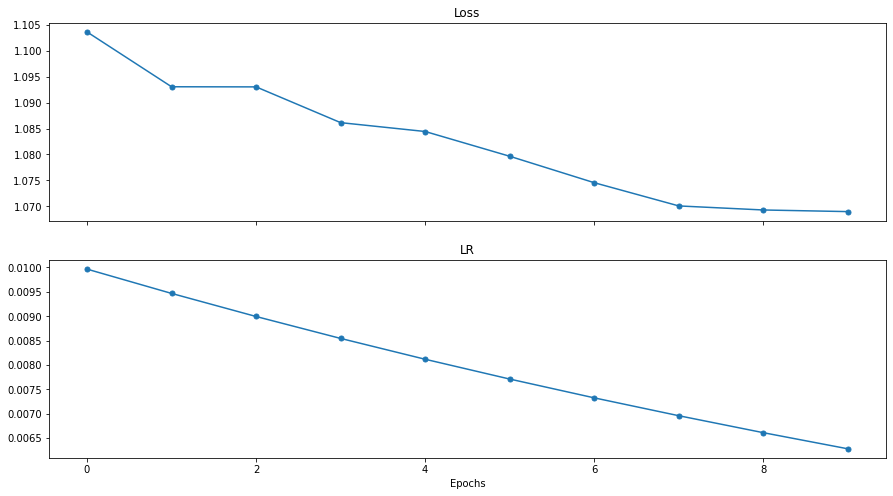

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

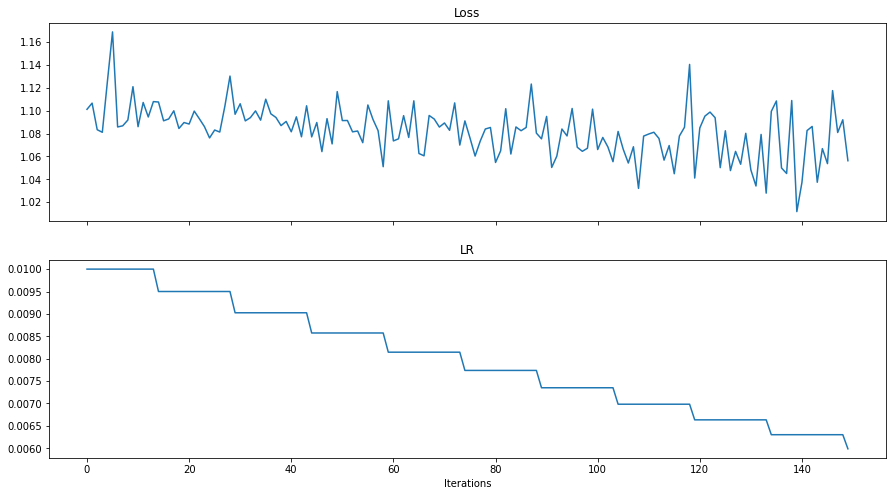

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

In [25]:
parameters = [base_coin, quote_coin, resolution, lookback_period, forecast_period]
model_fn = "{}_{}_{}_{}_{}.pth".format(*parameters)
model_fp = os.path.join("Models", "Trend-Classification", model_fn)
print(model_fp)

Models/Trend-Classification/BNB_BTC_1d_30_4.pth


In [26]:
torch.save(model.state_dict(), model_fp)

## 4. Define prediction

In [27]:
base_coin = "BNB"
quote_coin = "BTC"
dt_format = "%Y-%m-%dT%H:%M:%S"
min_time = "2020-01-01T00:00:00"
max_time = "2020-05-30T00:00:00"
resolution = resolution
lookback_period = lookback_period
forecast_period_train = 4
forecast_period_predict = 1###
mode = 'predict'

min_time = pd.to_datetime(min_time, format=dt_format)
max_time = pd.to_datetime(max_time, format=dt_format)

In [28]:
dataset = MarketDataset(base_coin=base_coin, 
                        quote_coin=quote_coin, 
                        min_time=min_time, 
                        max_time=max_time, 
                        resolution=resolution,
                        lookback_period=lookback_period, 
                        forecast_period=forecast_period_predict,
                        mode=mode)
print(len(dataset))


Finding valid indices...
Done
104


In [29]:
x, y, lookback_end_time, normalizing_parameters = dataset[len(dataset)-1]
print(x.shape, y, lookback_end_time)
print(pd.Timestamp(lookback_end_time, unit='s'), "UTC")

torch.Size([30, 5]) None 1589328000
2020-05-13 00:00:00 UTC


In [30]:
parameters = [base_coin, quote_coin, resolution, lookback_period, forecast_period_train]
model_fn = "{}_{}_{}_{}_{}.pth".format(*parameters)
model_fp = os.path.join("Models", "Trend-Classification", model_fn)

In [31]:
model = Model(input_size=input_size,
              hidden_size=hidden_size, 
              num_layers=num_layers,
              num_classes=num_classes,
              forecast_period=forecast_period).double()
model.load_state_dict(torch.load(model_fp))
model.eval()

Model(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
)

In [32]:
index = len(dataset)-5
x, y, lookback_end_time, normalizing_parameters = dataset[index]
X = x.unsqueeze(0)
Y_pred = model(X)
print("Lookback endtime (Last Open-Time): {} UTC".format(pd.Timestamp(lookback_end_time, unit='s')))
print("Resolution: {}".format(resolution))
probabilities = torch.exp(Y_pred)
probabilities /= probabilities.sum(axis=1)
probabilities = probabilities.detach().numpy()
indices = torch.argmax(Y_pred, dim=1).detach().numpy()
print("Future predictions...")
print(Y_pred)
print(probabilities)
print(indices)

Lookback endtime (Last Open-Time): 2020-05-09 00:00:00 UTC
Resolution: 1d
Future predictions...
tensor([[[ 0.1053,  0.1907,  0.1138,  0.1348],
         [ 0.0090, -0.0781, -0.1366, -0.0403],
         [-0.2888, -0.1894, -0.2846, -0.1703]]], dtype=torch.float64,
       grad_fn=<ViewBackward>)
[[[0.38722071 0.40849583 0.40818676 0.38814407]
  [0.35168723 0.31219506 0.3177677  0.32578311]
  [0.26109206 0.27930911 0.27404554 0.28607282]]]
[[0 0 0 0]]


In [33]:
dataset.data[['Open-Time', 'Close-Change', 'Close-Change-Class']].tail()

,Open-Time,Close-Change,Close-Change-Class
129,2020-05-09,0.005893,2
130,2020-05-10,0.000853,2
131,2020-05-11,0.001478,2
132,2020-05-12,0.017023,2
133,2020-05-13,-0.007811,2
